# Introduction

## 퍼널(Funnel)

> 사용자가 목표 행동에 도달할 때까지 거치는 단계(step)를 순서대로 나열한 것

각 단계에 도달한 사용자 수가 단계별로 줄어드는 현상을 수치로 분석하는 것을 의미한다. 서비스에서 어디가 문제인지 한눈에 드러내준다.

### 퍼널이 알려주는 것

- 이탈이 가장 많이 발생한 지점(드롭오프 지점)
- 단계별 전환율(CVR)
- 전체 전환율
- 어떤 세그먼트가 더 잘 전환되는가
- 어떤 개선이 가장 효과가 있는가

### 이 프로젝트에서의 퍼널 정의

| 단계 | 설명 |
| -- | -- |
| AppOpen | 서비스 유입 |
| ViewMenu | 탐색 의도 확인 |
| AddToCart | 구매 의도 확인 |
| CheckoutStart | 결제 시도 |
| PaymentSuccess | 최종 구매 | 

## 1) 기본 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

events = pd.read_csv("../data/events_prepared.csv")
events["timestamp"] = pd.to_datetime(events["timestamp"])
print("Events loaded:", events.shape)
events.head()

Events loaded: (150549, 14)


,timestamp,user_id,session_id,event_type,menu_id,price,category,experiment_group,device,channel,event_date,event_hour,weekday,hour
0,2024-12-01 00:10:00,AAM,AAM_20241201_1,AppOpen,NaN,NaN,NaN,B,Android,organic,2024-12-01,0,6,0
1,2024-12-01 00:10:05,AAM,AAM_20241201_1,SearchMenu,NaN,NaN,NaN,B,Android,organic,2024-12-01,0,6,0
2,2024-12-01 00:10:12,AAM,AAM_20241201_1,ViewMenu,9.0,3900.0,coffee,B,Android,organic,2024-12-01,0,6,0
3,2024-12-01 00:10:21,AAM,AAM_20241201_1,ViewMenu,6.0,3600.0,coffee,B,Android,organic,2024-12-01,0,6,0
4,2024-12-01 00:16:00,ADY,ADY_20241201_1,AppOpen,NaN,NaN,NaN,B,iOS,organic,2024-12-01,0,6,0


## 2) Funnel 단계 정의

```plain text
AppOpen -> ViewMenu -> AddToCart -> CheckoutStart -> PaymentSuccess

In [3]:
funnel_steps = [
    "AppOpen",
    "ViewMenu",
    "AddToCart",
    "CheckoutStart",
    "PaymentSuccess"
]

## 3) 세션 단위로 이벤트 묶기

In [4]:
session_events = (
    events.groupby(["user_id", "session_id"])["event_type"]
          .apply(list)
          .reset_index(name="events_in_session")
)

session_events.head()

,user_id,session_id,events_in_session
0,AAA,AAA_20241201_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View..."
1,AAA,AAA_20241203_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, AddT..."
2,AAA,AAA_20241204_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu]"
3,AAA,AAA_20241207_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View..."
4,AAA,AAA_20241209_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View..."


## 4) 세션 단위로 step 도달 여부 플래그 생성

In [5]:
for step in funnel_steps:
    session_events[f"reached_{step}"] = session_events["events_in_session"].apply(
        lambda ev_list: step in ev_list
    )

session_events.head()

,user_id,session_id,events_in_session,reached_AppOpen,reached_ViewMenu,reached_AddToCart,reached_CheckoutStart,reached_PaymentSuccess
0,AAA,AAA_20241201_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View...",True,True,False,False,False
1,AAA,AAA_20241203_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, AddT...",True,True,True,False,False
2,AAA,AAA_20241204_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu]",True,True,False,False,False
3,AAA,AAA_20241207_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View...",True,True,False,False,False
4,AAA,AAA_20241209_1,"[AppOpen, SearchMenu, ViewMenu, ViewMenu, View...",True,True,True,False,False


## 5) Funnel 단계별 도달 수 계산

In [6]:
funnel_counts = {}

for step in funnel_steps:
    funnel_counts[step] = session_events[f"reached_{step}"].sum()

funnel_counts

{'AppOpen': np.int64(29210),
 'ViewMenu': np.int64(29210),
 'AddToCart': np.int64(16576),
 'CheckoutStart': np.int64(9184),
 'PaymentSuccess': np.int64(2009)}

## 6) CVR 계산용 DataFrame 만들기

In [7]:
funnel_df = pd.DataFrame({
    "step": funnel_steps,
    "count": [funnel_counts[s] for s in funnel_steps]
})

# 단계별 CVR (다음 단계 / 현재 단계)
funnel_df["cvr_to_next"] = funnel_df["count"].shift(-1) / funnel_df["count"]

# 전체 CVR
overall_cvr = (
    funnel_df.loc[funnel_df["step"] == "PaymentSuccess", "count"].values[0]
    / funnel_df.loc[funnel_df["step"] == "AppOpen", "count"].values[0]
)

funnel_df, overall_cvr

(             step  count  cvr_to_next
 0         AppOpen  29210     1.000000
 1        ViewMenu  29210     0.567477
 2       AddToCart  16576     0.554054
 3   CheckoutStart   9184     0.218750
 4  PaymentSuccess   2009          NaN,
 np.float64(0.06877781581650119))

## 7) Funnel 바 차트 시각화

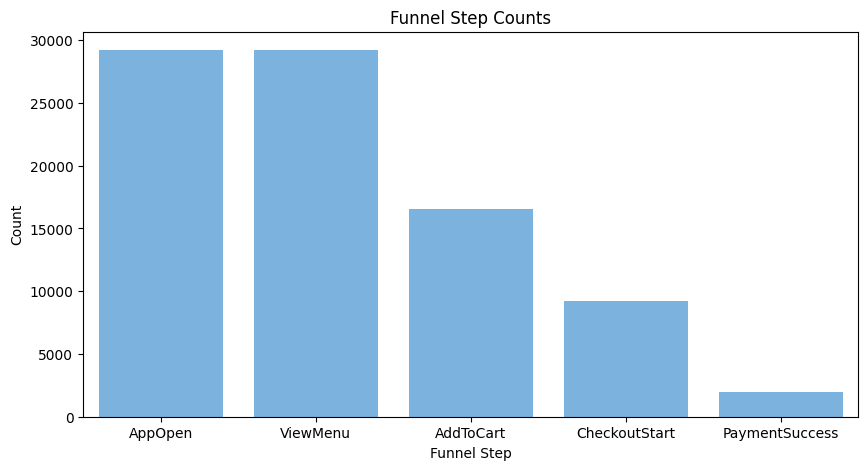

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=funnel_df,
    x="step",
    y="count",
    color="#6CB4EE"
)

plt.title("Funnel Step Counts")
plt.ylabel("Count")
plt.xlabel("Funnel Step")
plt.show()

## 8) 드롭오프 비율 추가 분석

In [ ]:
funnel_df["dropoff_rate"] = 1 - funnel_df["cvr_to_next"]
funnel_df

,step,count,cvr_to_next,dropoff_rate
0,AppOpen,29210,1.000000,0.000000
1,ViewMenu,29210,0.567477,0.432523
2,AddToCart,16576,0.554054,0.445946
3,CheckoutStart,9184,0.218750,0.781250
4,PaymentSuccess,2009,NaN,NaN


## 9) 퍼널 분석 자동 설명 생성

In [10]:
print("==== Funnel Conversion Summary ====")
for i in range(len(funnel_steps) - 1):
    step = funnel_steps[i]
    next_step = funnel_steps[i+1]
    cvr = funnel_df.loc[i, "cvr_to_next"]

    print(f"{step} -> {next_step}: 전환율 {cvr:.2%}")

print("\n전체 전환율 (AppOpen -> PaymentSuccess): {:.2%}".format(overall_cvr))

==== Funnel Conversion Summary ====
AppOpen -> ViewMenu: 전환율 100.00%
ViewMenu -> AddToCart: 전환율 56.75%
AddToCart -> CheckoutStart: 전환율 55.41%
CheckoutStart -> PaymentSuccess: 전환율 21.88%

전체 전환율 (AppOpen -> PaymentSuccess): 6.88%
